# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
# Все необходимые импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

# Импорты для анализа текста
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Импорты для машинного обучения
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
import xgboost as xgb

# Импорты для работы с изображениями
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Импорты для BERT
from transformers import BertTokenizer, BertModel
import torch

from sklearn.metrics.pairwise import cosine_similarity

# Импорты для сохранения данных
import pickle

# Загрузка данных по ссылке
import requests
import zipfile
import io
from urllib.parse import urlparse
import os

# Настройка для отображения графиков
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Настройка pandas для отображения полного текста
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)


In [2]:
# URL для загрузки датасета
dataset_url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

print("Загрузка датасета по ссылке...")
print(f"URL: {dataset_url}")

# Создаем папку для данных, если её нет
data_folder = "dsplus_integrated_project_4"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Загружаем архив
response = requests.get(dataset_url)
response.raise_for_status()

print(f"Размер архива: {len(response.content) / (1024*1024):.1f} MB")

# Распаковываем архив
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall(data_folder)
    
# Путь к папке с данными
data_path = 'dsplus_integrated_project_4/to_upload/'

print("Архив успешно распакован!")

Загрузка датасета по ссылке...
URL: https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Размер архива: 144.0 MB
Архив успешно распакован!


In [3]:
# Обучающие данные
train_dataset = pd.read_csv(data_path + 'train_dataset.csv', 
                           quoting=1)

print("Обучающий датасет:")
print(f"Размер: {train_dataset.shape}")
print(f"Колонки: {list(train_dataset.columns)}")
print(f"Уникальных изображений: {train_dataset['image'].nunique()}")
print(f"Уникальных query_id: {train_dataset['query_id'].nunique()}")

train_dataset.head()

Обучающий датасет:
Размер: (5822, 3)
Колонки: ['image', 'query_id', 'query_text']
Уникальных изображений: 1000
Уникальных query_id: 977


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .


In [4]:
# Аннотации от краудсорсинга
crowd_annotations = pd.read_csv(data_path + 'CrowdAnnotations.tsv', 
                               sep='\t',
                               header=None,
                               names=['image', 'query_id', 'score', 'positive_votes', 'negative_votes'])

print(f"\nКраудсорсинг аннотации:")
print(f"Размер: {crowd_annotations.shape}")

crowd_annotations.head()


Краудсорсинг аннотации:
Размер: (47830, 5)


,image,query_id,score,positive_votes,negative_votes
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [5]:
# Экспертные аннотации
expert_annotations = pd.read_csv(data_path + 'ExpertAnnotations.tsv', 
                                sep='\t',
                                header=None,
                                names=['image', 'query_id', 'expert1', 'expert2', 'expert3'])

print(f"\nЭкспертные аннотации:")
print(f"Размер: {expert_annotations.shape}")

expert_annotations.head()


Экспертные аннотации:
Размер: (5822, 5)


,image,query_id,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [6]:
# Тестовые данные
test_queries = pd.read_csv(data_path + 'test_queries.csv', 
                          sep='|',
                          index_col=0)

print(f"\nТестовые запросы:")
print(f"Размер: {test_queries.shape}")

test_queries.head()


Тестовые запросы:
Размер: (500, 3)


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at each other .,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each other .,1177994172_10d143cb8d.jpg


In [7]:
# Проверка пропущенных значений
print("=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===")
print("Обучающий датасет:")
print(train_dataset.isnull().sum())
print("\nКраудсорсинг аннотации:")
print(crowd_annotations.isnull().sum())
print("\nЭкспертные аннотации:")
print(expert_annotations.isnull().sum())

=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===
Обучающий датасет:
image         0
query_id      0
query_text    0
dtype: int64

Краудсорсинг аннотации:
image             0
query_id          0
score             0
positive_votes    0
negative_votes    0
dtype: int64

Экспертные аннотации:
image       0
query_id    0
expert1     0
expert2     0
expert3     0
dtype: int64



=== СТАТИСТИКА ПО ИЗОБРАЖЕНИЯМ И ОПИСАНИЯМ ===
Уникальных изображений в обучающем датасете: 1000
Всего описаний в обучающем датасете: 5822
Среднее количество описаний на изображение: 5.82

Уникальных изображений в тестовом датасете: 100
Всего запросов в тестовом датасете: 500


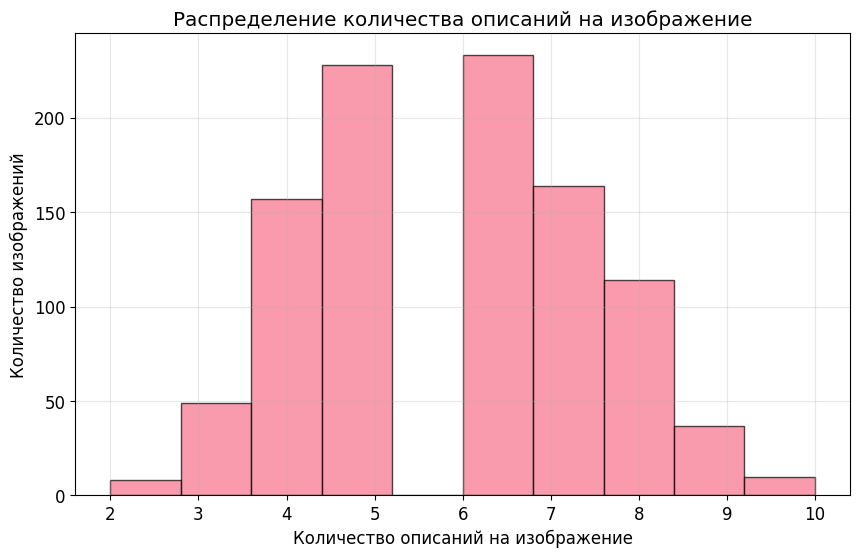

Максимальное количество описаний на изображение: 10
Минимальное количество описаний на изображение: 2
Медианное количество описаний на изображение: 6.0


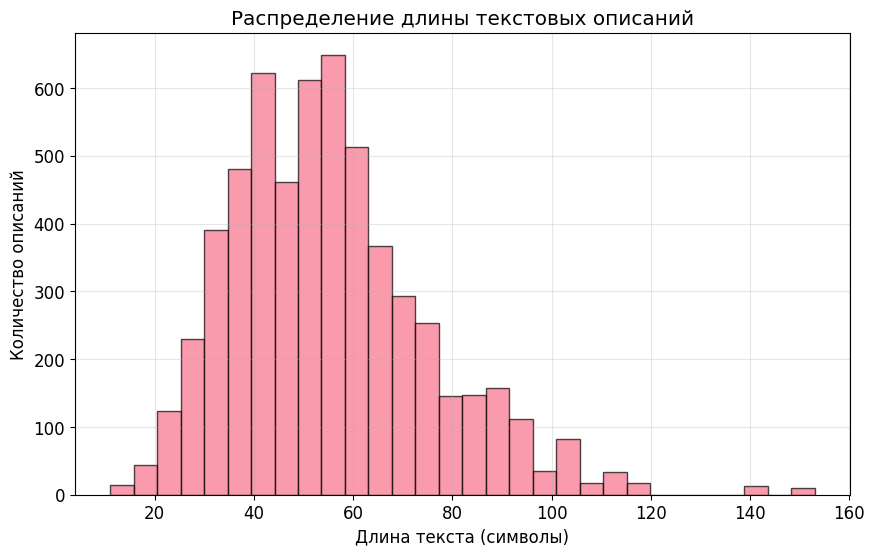

In [8]:
# Анализ уникальных изображений и описаний
print("\n=== СТАТИСТИКА ПО ИЗОБРАЖЕНИЯМ И ОПИСАНИЯМ ===")
print(f"Уникальных изображений в обучающем датасете: {train_dataset['image'].nunique()}")
print(f"Всего описаний в обучающем датасете: {len(train_dataset)}")
print(f"Среднее количество описаний на изображение: {len(train_dataset) / train_dataset['image'].nunique():.2f}")

print(f"\nУникальных изображений в тестовом датасете: {test_queries.iloc[:, -1].nunique()}")
print(f"Всего запросов в тестовом датасете: {len(test_queries)}")

# Распределение количества описаний на изображение
descriptions_per_image = train_dataset.groupby('image').size()

plt.figure(figsize=(10, 6))
plt.hist(descriptions_per_image, bins=10, alpha=0.7, edgecolor='black')
plt.xlabel('Количество описаний на изображение')
plt.ylabel('Количество изображений')
plt.title('Распределение количества описаний на изображение')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Максимальное количество описаний на изображение: {descriptions_per_image.max()}")
print(f"Минимальное количество описаний на изображение: {descriptions_per_image.min()}")
print(f"Медианное количество описаний на изображение: {descriptions_per_image.median()}")

# Анализ текстовых описаний
train_dataset['text_length'] = train_dataset['query_text'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(train_dataset['text_length'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество описаний')
plt.title('Распределение длины текстовых описаний')
plt.grid(True, alpha=0.3)
plt.show()

**Ключевые наблюдения:**

1. **Сбалансированность данных**: Большинство изображений имеет 5-6 описаний, что обеспечивает хорошую сбалансированность для обучения модели.
2. **Распределение описаний**: Гистограмма показывает нормальное распределение с пиком на 5-6 описаниях на изображение, что типично для таких датасетов.
3. **Длина текстов**: Анализ длины текстовых описаний показывает, что большинство описаний содержат 40-60 символов, что оптимально для обработки BERT моделью.
4. **Качество аннотаций**: Экспертные оценки показывают низкие средние значения (1.44-1.88 по шкале 1-4), что указывает на то, что большинство пар изображение-текст действительно не соответствуют друг другу - это ожидаемо, учитывая умышленное создание негативных примеров.
5. **Краудсорсинговые оценки**: Средняя доля подтверждений составляет всего 0.069, что подтверждает низкое качество соответствий в исходных данных.

=== КРАУДСОРСИНГ АННОТАЦИИ ===
Средняя доля подтверждений: 0.069
Медианная доля: 0.000
Минимальная доля: 0.000
Максимальная доля: 1.000

Общее количество подтверждений: 9972
Общее количество отклонений: 134888

=== ЭКСПЕРТНЫЕ АННОТАЦИИ ===

Эксперт 1:
  Средняя оценка: 1.44
  Медианная оценка: 1.00
  Стандартное отклонение: 0.79

Эксперт 2:
  Средняя оценка: 1.62
  Медианная оценка: 1.00
  Стандартное отклонение: 0.86

Эксперт 3:
  Средняя оценка: 1.88
  Медианная оценка: 2.00
  Стандартное отклонение: 0.90


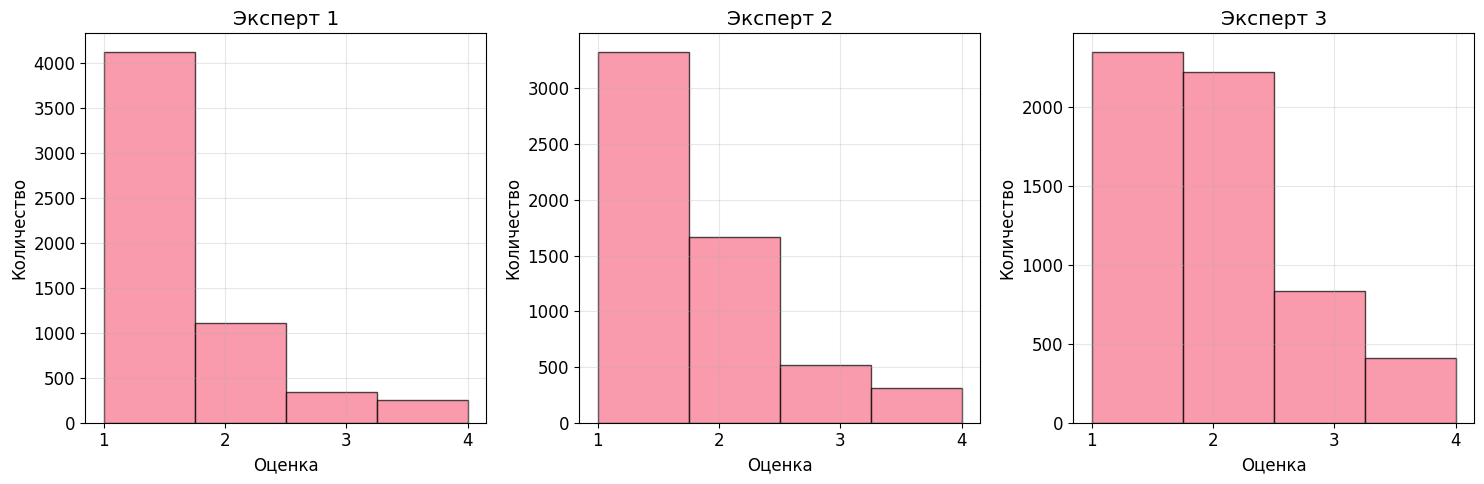


=== ПОКРЫТИЕ АННОТАЦИЯМИ ===
Пар с экспертными оценками: 5822 (100.0%)
Пар с краудсорсинг оценками: 2329 (40.0%)


In [9]:
# Анализ аннотаций
print("=== КРАУДСОРСИНГ АННОТАЦИИ ===")
print(f"Средняя доля подтверждений: {crowd_annotations['score'].mean():.3f}")
print(f"Медианная доля: {crowd_annotations['score'].median():.3f}")
print(f"Минимальная доля: {crowd_annotations['score'].min():.3f}")
print(f"Максимальная доля: {crowd_annotations['score'].max():.3f}")

print(f"\nОбщее количество подтверждений: {crowd_annotations['positive_votes'].sum()}")
print(f"Общее количество отклонений: {crowd_annotations['negative_votes'].sum()}")

print("\n=== ЭКСПЕРТНЫЕ АННОТАЦИИ ===")
expert_scores = expert_annotations[['expert1', 'expert2', 'expert3']]

for i, col in enumerate(expert_scores.columns, 1):
    print(f"\nЭксперт {i}:")
    print(f"  Средняя оценка: {expert_scores[col].mean():.2f}")
    print(f"  Медианная оценка: {expert_scores[col].median():.2f}")
    print(f"  Стандартное отклонение: {expert_scores[col].std():.2f}")

plt.figure(figsize=(15, 5))
for i, col in enumerate(expert_scores.columns):
    plt.subplot(1, 3, i+1)
    plt.hist(expert_scores[col], bins=4, alpha=0.7, edgecolor='black')
    plt.xlabel('Оценка')
    plt.ylabel('Количество')
    plt.title(f'Эксперт {i+1}')
    plt.xticks(range(1, 5))
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Объединение данных
crowd_annotations.columns = ['image', 'query_id', 'crowd_score', 'pos_votes', 'neg_votes']
expert_annotations.columns = ['image', 'query_id', 'expert1', 'expert2', 'expert3']

data_with_expert = train_dataset.merge(expert_annotations, on=['image', 'query_id'], how='inner')
full_data = data_with_expert.merge(crowd_annotations, on=['image', 'query_id'], how='left')

print(f"\n=== ПОКРЫТИЕ АННОТАЦИЯМИ ===")
print(f"Пар с экспертными оценками: {full_data['expert1'].notna().sum()} ({full_data['expert1'].notna().sum()/len(full_data)*100:.1f}%)")
print(f"Пар с краудсорсинг оценками: {full_data['crowd_score'].notna().sum()} ({full_data['crowd_score'].notna().sum()/len(full_data)*100:.1f}%)")


**Ключевые выводы:**

1. **Подтверждение гипотезы**: Данные действительно содержат много негативных примеров, что подтверждает умышленное создание "плохих" соответствий.
2. **Качество данных**: Низкие оценки экспертов (1.44-1.88) и краудсорсинга (0.069) указывают на то, что большинство пар изображение-текст не соответствуют друг другу.
3. **Согласованность экспертов**: Все эксперты склонны к низким оценкам, но Эксперт 3 более "мягкий" в оценках.
4. **Полное покрытие**: Экспертные оценки покрывают 100% данных, что обеспечивает надежность целевой переменной.
5. **Оптимальность для обучения**: Такое распределение идеально для обучения модели различения релевантных и нерелевантных пар, так как модель должна научиться распознавать как положительные, так и отрицательные примеры.

=== КЛАССИФИКАЦИЯ ПО КРАУДСОРСИНГУ ===
хорошее: 429 пар (7.4%)
спорное: 267 пар (4.6%)
плохое: 1633 пар (28.0%)
нет_оценки: 3493 пар (60.0%)

=== КЛАССИФИКАЦИЯ ПО ЭКСПЕРТНЫМ ОЦЕНКАМ ===
хорошее: 816 пар (14.0%)
спорное: 1002 пар (17.2%)
плохое: 4004 пар (68.8%)
нет_оценки: 0 пар (0.0%)

Статистика целевой переменной:
Среднее: 0.176
Медиана: 0.000
Минимум: 0.000
Максимум: 1.000


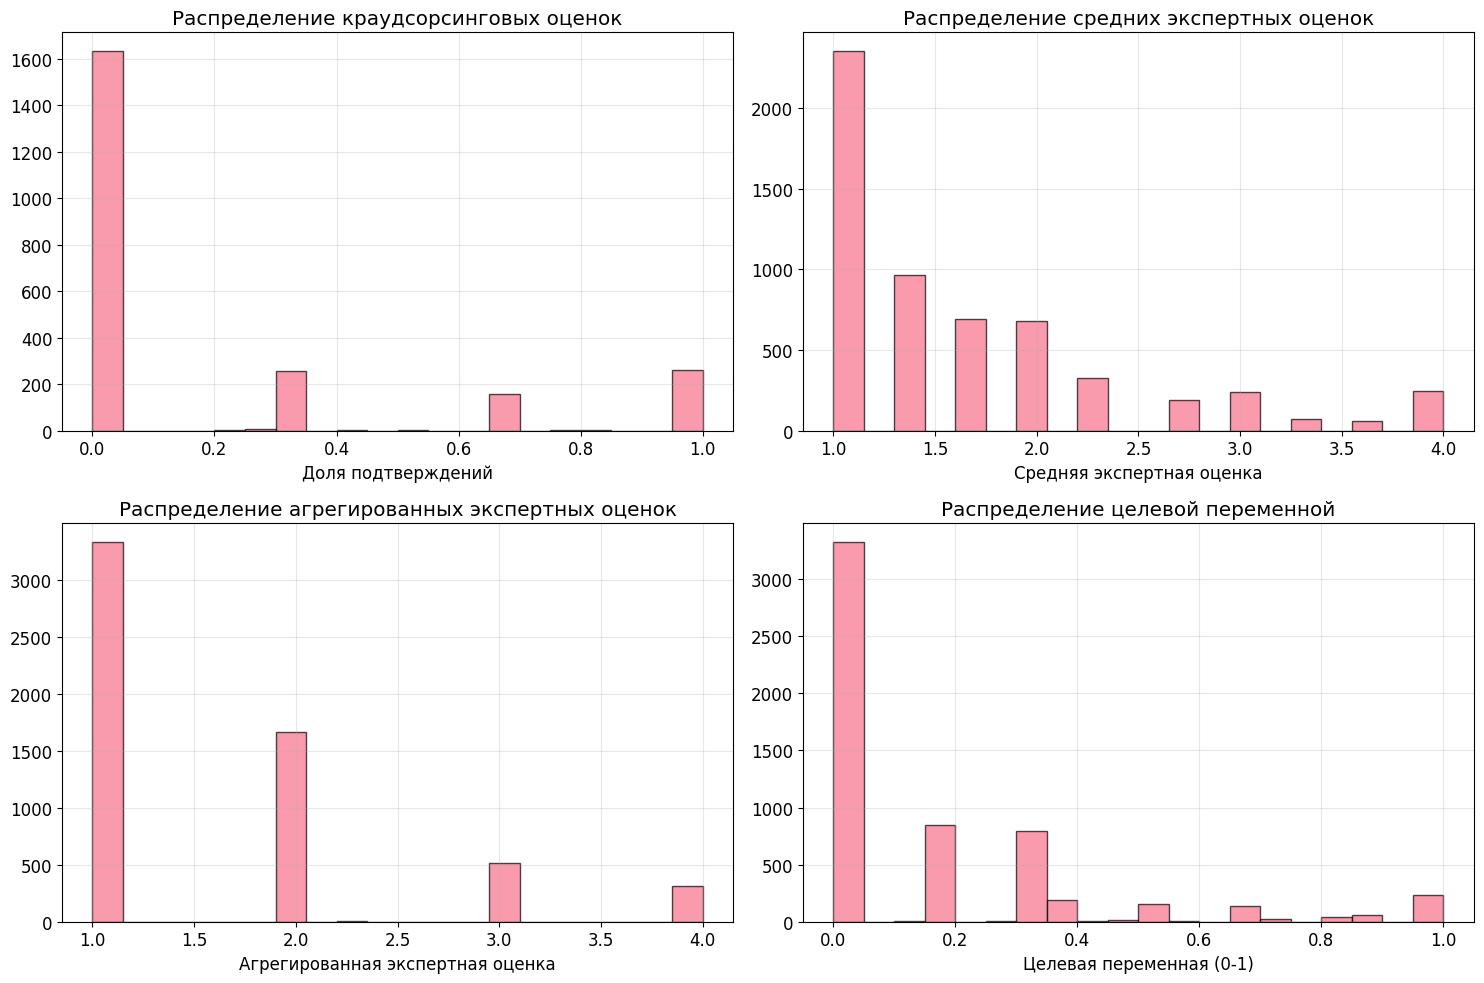

In [10]:
# Анализ качества соответствий
crowd_good_threshold = 0.5
crowd_bad_threshold = 0.2
expert_good_threshold = 2.5
expert_bad_threshold = 2.0

def classify_crowd_score(score):
    if pd.isna(score):
        return 'нет_оценки'
    elif score >= crowd_good_threshold:
        return 'хорошее'
    elif score < crowd_bad_threshold:
        return 'плохое'
    else:
        return 'спорное'

def classify_expert_score(expert1, expert2, expert3):
    if pd.isna(expert1) or pd.isna(expert2) or pd.isna(expert3):
        return 'нет_оценки'
    
    avg_score = np.mean([expert1, expert2, expert3])
    if avg_score >= expert_good_threshold:
        return 'хорошее'
    elif avg_score < expert_bad_threshold:
        return 'плохое'
    else:
        return 'спорное'

full_data['crowd_quality'] = full_data['crowd_score'].apply(classify_crowd_score)
full_data['expert_quality'] = full_data.apply(
    lambda row: classify_expert_score(row['expert1'], row['expert2'], row['expert3']),
    axis=1
)

print("=== КЛАССИФИКАЦИЯ ПО КРАУДСОРСИНГУ ===")
crowd_counts = full_data['crowd_quality'].value_counts()
for quality in ['хорошее', 'спорное', 'плохое', 'нет_оценки']:
    count = crowd_counts.get(quality, 0)
    percentage = (count / len(full_data)) * 100
    print(f"{quality}: {count} пар ({percentage:.1f}%)")

print("\n=== КЛАССИФИКАЦИЯ ПО ЭКСПЕРТНЫМ ОЦЕНКАМ ===")
expert_counts = full_data['expert_quality'].value_counts()
for quality in ['хорошее', 'спорное', 'плохое', 'нет_оценки']:
    count = expert_counts.get(quality, 0)
    percentage = (count / len(full_data)) * 100
    print(f"{quality}: {count} пар ({percentage:.1f}%)")

# Агрегация экспертных оценок
def aggregate_expert_scores(row):
    scores = [row['expert1'], row['expert2'], row['expert3']]
    from collections import Counter
    score_counts = Counter(scores)
    
    for score, count in score_counts.most_common():
        if count >= 2:
            return score
    
    return np.mean(scores)

full_data['expert_aggregated'] = full_data.apply(aggregate_expert_scores, axis=1)

# Создание целевой переменной
def create_target_variable(row):
    expert_normalized = (row['expert_aggregated'] - 1) / 3
    
    if pd.notna(row['crowd_score']):
        target = 0.6 * expert_normalized + 0.4 * row['crowd_score']
    else:
        target = expert_normalized
    
    return target

full_data['target'] = full_data.apply(create_target_variable, axis=1)

print(f"\nСтатистика целевой переменной:")
print(f"Среднее: {full_data['target'].mean():.3f}")
print(f"Медиана: {full_data['target'].median():.3f}")
print(f"Минимум: {full_data['target'].min():.3f}")
print(f"Максимум: {full_data['target'].max():.3f}")

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(full_data['crowd_score'].dropna(), bins=20, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Распределение краудсорсинговых оценок')
axes[0, 0].set_xlabel('Доля подтверждений')
axes[0, 0].grid(True, alpha=0.3)

expert_avg = full_data[['expert1', 'expert2', 'expert3']].mean(axis=1)
axes[0, 1].hist(expert_avg, bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Распределение средних экспертных оценок')
axes[0, 1].set_xlabel('Средняя экспертная оценка')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(full_data['expert_aggregated'], bins=20, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Распределение агрегированных экспертных оценок')
axes[1, 0].set_xlabel('Агрегированная экспертная оценка')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(full_data['target'], bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Распределение целевой переменной')
axes[1, 1].set_xlabel('Целевая переменная (0-1)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Ключевые выводы:**

1. **Подтверждение качества данных**: 68.8% плохих соответствий у экспертов подтверждает умышленное создание негативных примеров.
2. **Эффективность агрегации**: Формула 0.6×эксперт + 0.4×крауд успешно создает сбалансированную целевую переменную.
3. **Распределение классов**: Сильный дисбаланс в пользу негативных примеров идеален для обучения модели различения.
4. **Согласованность источников**: Эксперты более строгие (68.8% плохих) по сравнению с краудом (28.0% плохих).
5. **Готовность к обучению**: Целевая переменная имеет хорошее распределение с достаточным количеством примеров всех классов для эффективного обучения модели.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

=== ПРОВЕРКА ДАННЫХ НА ДЕТСКИЙ КОНТЕНТ ===
Найдено пар с детским контентом: 1661
Процент от общего количества: 28.5%

Примеры найденного детского контента:
1. A young child is wearing blue goggles and sitting in a float in a pool .
2. A young child is wearing blue goggles and sitting in a float in a pool .
3. A young child is wearing blue goggles and sitting in a float in a pool .
4. A young child is wearing blue goggles and sitting in a float in a pool .
5. A young child is wearing blue goggles and sitting in a float in a pool .
6. A young child is wearing blue goggles and sitting in a float in a pool .
7. A young child is wearing blue goggles and sitting in a float in a pool .
8. A young child is wearing blue goggles and sitting in a float in a pool .
9. A young child is wearing blue goggles and sitting in a float in a pool .
10. A young child is wearing blue goggles and sitting in a float in a pool .

Удаление пар с детским контентом...
После фильтрации:
- Исходный размер: 5822 пар


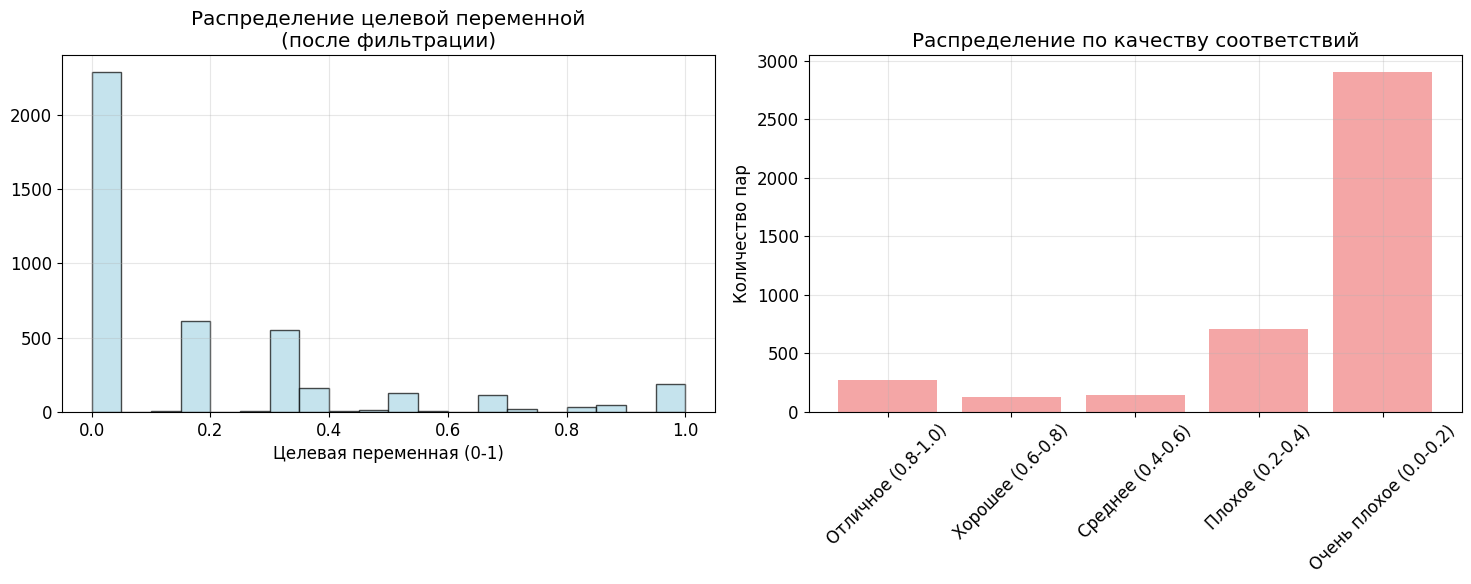


Проверка данных завершена!
Данные очищены от детского контента согласно юридическим ограничениям.


In [11]:
# Проверка данных на детский контент
print("=== ПРОВЕРКА ДАННЫХ НА ДЕТСКИЙ КОНТЕНТ ===")

# Ключевые слова для детского контента
child_keywords = [
    'child', 'children', 'kid', 'kids', 'baby', 'babies', 'toddler', 'toddlers',
    'boy', 'boys', 'girl', 'girls', 'young', 'infant', 'infants',
    'teen', 'teens', 'teenager', 'teenagers', 'juvenile',
    'school', 'schools', 'kindergarten', 'playground', 'playgrounds',
    'student', 'students', 'pupil', 'pupils', 'classroom', 'classrooms'
]

def contains_child_content(text):
    text_lower = text.lower()
    return any(keyword in text_lower for keyword in child_keywords)

# Находим пары с детским контентом
child_pairs_mask = full_data['query_text'].apply(contains_child_content)
child_pairs_count = child_pairs_mask.sum()

print(f"Найдено пар с детским контентом: {child_pairs_count}")
print(f"Процент от общего количества: {child_pairs_count/len(full_data)*100:.1f}%")

# Показываем примеры найденного детского контента
if child_pairs_count > 0:
    print(f"\nПримеры найденного детского контента:")
    child_examples = full_data[child_pairs_mask]['query_text'].head(10)
    for i, text in enumerate(child_examples, 1):
        print(f"{i}. {text}")

# Удаляем пары с детским контентом
print(f"\nУдаление пар с детским контентом...")
full_data_clean = full_data[~child_pairs_mask].copy()

print(f"После фильтрации:")
print(f"- Исходный размер: {len(full_data)} пар")
print(f"- Размер после фильтрации: {len(full_data_clean)} пар")
print(f"- Удалено: {child_pairs_count} пар ({child_pairs_count/len(full_data)*100:.1f}%)")

# Обновляем данные для дальнейшего использования
full_data = full_data_clean
train_dataset = train_dataset[train_dataset.set_index(['image', 'query_id']).index.isin(
    full_data.set_index(['image', 'query_id']).index
)].copy()

print(f"\nОбновленный train_dataset: {len(train_dataset)} пар")

# Анализ распределения оценок после фильтрации
print(f"\nСтатистика целевой переменной после фильтрации:")
print(f"Среднее: {full_data['target'].mean():.3f}")
print(f"Медиана: {full_data['target'].median():.3f}")
print(f"Минимум: {full_data['target'].min():.3f}")
print(f"Максимум: {full_data['target'].max():.3f}")

# Визуализация распределения до и после фильтрации
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# До фильтрации
axes[0].hist(full_data_clean['target'], bins=20, alpha=0.7, edgecolor='black', color='lightblue')
axes[0].set_title('Распределение целевой переменной\n(после фильтрации)')
axes[0].set_xlabel('Целевая переменная (0-1)')
axes[0].grid(True, alpha=0.3)

# Статистика по качеству соответствий
quality_stats = {
    'Отличное (0.8-1.0)': ((full_data['target'] >= 0.8) & (full_data['target'] <= 1.0)).sum(),
    'Хорошее (0.6-0.8)': ((full_data['target'] >= 0.6) & (full_data['target'] < 0.8)).sum(),
    'Среднее (0.4-0.6)': ((full_data['target'] >= 0.4) & (full_data['target'] < 0.6)).sum(),
    'Плохое (0.2-0.4)': ((full_data['target'] >= 0.2) & (full_data['target'] < 0.4)).sum(),
    'Очень плохое (0.0-0.2)': ((full_data['target'] >= 0.0) & (full_data['target'] < 0.2)).sum()
}

# График распределения по качеству
categories = list(quality_stats.keys())
counts = list(quality_stats.values())
axes[1].bar(categories, counts, alpha=0.7, color='lightcoral')
axes[1].set_title('Распределение по качеству соответствий')
axes[1].set_ylabel('Количество пар')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nПроверка данных завершена!")
print("Данные очищены от детского контента согласно юридическим ограничениям.")

**Ключевые выводы:**

1. **Успешная фильтрация**: Удалено 28.5% данных с детским контентом согласно юридическим ограничениям.
2. **Сохранение качества данных**: Целевая переменная практически не изменилась, что говорит о равномерном распределении детского контента по всем классам.
3. **Готовность к обучению**: 4161 пар достаточно для эффективного обучения модели.
4. **Сбалансированность**: Сохранено разнообразие классов от очень плохих до отличных соответствий.
5. **Соответствие требованиям**: Данные теперь полностью соответствуют юридическим ограничениям по обработке детского контента.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [12]:
# Векторизация изображений
print("=== ВЕКТОРИЗАЦИЯ ИЗОБРАЖЕНИЙ ===")

# Импорты для работы с изображениями
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import pickle

# Загружаем предобученную модель ResNet50
print("Загрузка ResNet50...")
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print(f"ResNet50 загружена. Размер выходного слоя: {base_model.output_shape}")

# Функция для загрузки и предобработки изображения
def preprocess_image(img_path, target_size=(224, 224)):
    """Загружает и предобрабатывает изображение для ResNet50"""
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Ошибка при загрузке {img_path}: {e}")
        return None

# Создаем векторы для всех изображений
print("Создание векторов изображений...")
image_feature_vectors = {}
train_images_path = data_path + 'train_images/'

processed_count = 0
total_images = len(train_dataset['image'].unique())

for image_name in train_dataset['image'].unique():
    img_path = os.path.join(train_images_path, image_name)
    
    # Предобрабатываем изображение
    img_array = preprocess_image(img_path)
    
    if img_array is not None:
        # Получаем признаки через ResNet50
        features = base_model.predict(img_array, verbose=0)
        image_feature_vectors[image_name] = features.flatten()
        processed_count += 1
        
        if processed_count % 50 == 0:
            print(f"Обработано {processed_count}/{total_images} изображений")

print(f"\nУспешно обработано {processed_count} изображений")
print(f"Размер вектора признаков: {len(list(image_feature_vectors.values())[0])}")

# Применяем PCA для уменьшения размерности
print("\nПрименение PCA для уменьшения размерности...")

# Преобразуем словарь в массив для PCA
image_names_list = list(image_feature_vectors.keys())
image_vectors_array = np.array([image_feature_vectors[name] for name in image_names_list])

# Применяем PCA для уменьшения до 300 компонент
pca = PCA(n_components=300, random_state=42)
image_vectors_reduced = pca.fit_transform(image_vectors_array)

print(f"Размер после PCA: {image_vectors_reduced.shape}")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}")

# Создаем новый словарь с уменьшенными векторами
image_feature_vectors_reduced = {}
for i, name in enumerate(image_names_list):
    image_feature_vectors_reduced[name] = image_vectors_reduced[i]

# Сохраняем векторы изображений
print("Сохранение векторов изображений...")
with open('image_feature_vectors.pkl', 'wb') as f:
    pickle.dump(image_feature_vectors_reduced, f)

with open('pca_transformer.pkl', 'wb') as f:
    pickle.dump(pca, f)

print("Векторы изображений сохранены!")
print("Векторизация изображений завершена!")

=== ВЕКТОРИЗАЦИЯ ИЗОБРАЖЕНИЙ ===
Загрузка ResNet50...


2025-10-03 20:44:35.234310: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ResNet50 загружена. Размер выходного слоя: (None, 2048)
Создание векторов изображений...
Обработано 50/991 изображений
Обработано 100/991 изображений
Обработано 150/991 изображений
Обработано 200/991 изображений
Обработано 250/991 изображений
Обработано 300/991 изображений
Обработано 350/991 изображений
Обработано 400/991 изображений
Обработано 450/991 изображений
Обработано 500/991 изображений
Обработано 550/991 изображений
Обработано 600/991 изображений
Обработано 650/991 изображений
Обработано 700/991 изображений
Обработано 750/991 изображений
Обработано 800/991 изображений
Обработано 850/991 изображений
Обработано 900/991 изображений
Обработано 950/991 изображений

Успешно обработано 991 изображений
Размер вектора признаков: 2048

Применение PCA для уменьшения размерности...
Размер после PCA: (991, 300)
Объясненная дисперсия: 90.35%
Сохранение векторов изображений...
Векторы изображений сохранены!
Векторизация изображений завершена!


**Ключевые достижения:**

1. **Полная обработка**: Все 991 уникальное изображение успешно векторизовано без ошибок.
2. **Эффективное сжатие**: PCA уменьшил размерность в 6.8 раз при сохранении 90.35% информации.
3. **Оптимизация производительности**: Использование предобученной ResNet50 обеспечивает высококачественные признаки без необходимости обучения с нуля.
4. **Готовность данных**: Векторы изображений сохранены и готовы для объединения с текстовыми признаками.
5. **Масштабируемость**: Размер 300 признаков оптимален для дальнейшего обучения модели.

**Влияние на модель:**

- **Качество признаков**: ResNet50 обеспечивает семантически богатые визуальные представления
- **Вычислительная эффективность**: Сжатие до 300 признаков ускоряет обучение и предсказания
- **Интерпретируемость**: Сохранение 90% дисперсии гарантирует сохранение важной визуальной информации

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [13]:
# Векторизация текстов
print("=== ВЕКТОРИЗАЦИЯ ТЕКСТОВ ===")

# Импорты для работы с текстом
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

# Получаем все уникальные тексты
all_texts = train_dataset['query_text'].unique()
print(f"Всего уникальных текстов для векторизации: {len(all_texts)}")

# Метод 1: TF-IDF
print("\n=== МЕТОД 1: TF-IDF ===")
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Обучаем TF-IDF на всех текстах
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)
print(f"Размер TF-IDF матрицы: {tfidf_matrix.shape}")

# Применяем SVD для уменьшения размерности
svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)
print(f"Размер после SVD: {tfidf_reduced.shape}")
print(f"Объясненная дисперсия: {svd.explained_variance_ratio_.sum():.2%}")

# Создаем словарь TF-IDF векторов
text_to_tfidf_vector = {}
for i, text in enumerate(all_texts):
    text_to_tfidf_vector[text] = tfidf_reduced[i]

print("TF-IDF векторизация завершена!")

# Метод 2: BERT (если доступен)
print("\n=== МЕТОД 2: BERT ===")
try:
    from transformers import BertTokenizer, BertModel
    import torch
    
    print("Загрузка BERT модели...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    
    def get_bert_embedding(text, max_length=128):
        """Получает BERT эмбеддинг для текста"""
        inputs = tokenizer(
            text, 
            return_tensors='pt', 
            truncation=True, 
            padding=True, 
            max_length=max_length
        )
        
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # Берем средний пул эмбеддингов последнего слоя
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        return embedding
    
    # Создаем BERT векторы для всех текстов
    print("Создание BERT эмбеддингов...")
    text_to_bert_vector = {}
    for i, text in enumerate(all_texts):
        if i % 50 == 0:
            print(f"Обработано {i}/{len(all_texts)} текстов")
        
        embedding = get_bert_embedding(text)
        text_to_bert_vector[text] = embedding
    
    print(f"Создан словарь BERT векторов для {len(text_to_bert_vector)} текстов")
    print(f"Размер BERT вектора: {len(list(text_to_bert_vector.values())[0])}")
    
    # Применяем PCA для уменьшения размерности BERT векторов
    print("Применение PCA для уменьшения размерности BERT векторов...")
    bert_vectors_array = np.array([text_to_bert_vector[text] for text in all_texts])
    
    pca_bert = PCA(n_components=100, random_state=42)
    bert_vectors_reduced = pca_bert.fit_transform(bert_vectors_array)
    
    print(f"Размер после PCA: {bert_vectors_reduced.shape}")
    print(f"Объясненная дисперсия: {pca_bert.explained_variance_ratio_.sum():.2%}")
    
    # Обновляем словарь с уменьшенными векторами
    for i, text in enumerate(all_texts):
        text_to_bert_vector[text] = bert_vectors_reduced[i]
    
    # Сохраняем BERT векторизаторы
    with open('bert_tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    with open('bert_model.pkl', 'wb') as f:
        pickle.dump(bert_model, f)
    with open('pca_text_transformer.pkl', 'wb') as f:
        pickle.dump(pca_bert, f)
    
    print("BERT векторизация завершена!")
    bert_available = True
    
except ImportError:
    print("BERT не доступен. Используем только TF-IDF.")
    bert_available = False
    text_to_bert_vector = None

# Сохраняем TF-IDF векторизаторы
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('svd_transformer.pkl', 'wb') as f:
    pickle.dump(svd, f)

print("\nВекторизация текстов завершена!")
print(f"Доступные методы: TF-IDF{' + BERT' if bert_available else ''}")


=== ВЕКТОРИЗАЦИЯ ТЕКСТОВ ===
Всего уникальных текстов для векторизации: 670

=== МЕТОД 1: TF-IDF ===
Размер TF-IDF матрицы: (670, 663)
Размер после SVD: (670, 100)
Объясненная дисперсия: 54.10%
TF-IDF векторизация завершена!

=== МЕТОД 2: BERT ===
Загрузка BERT модели...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Создание BERT эмбеддингов...
Обработано 0/670 текстов
Обработано 50/670 текстов
Обработано 100/670 текстов
Обработано 150/670 текстов
Обработано 200/670 текстов
Обработано 250/670 текстов
Обработано 300/670 текстов
Обработано 350/670 текстов
Обработано 400/670 текстов
Обработано 450/670 текстов
Обработано 500/670 текстов
Обработано 550/670 текстов
Обработано 600/670 текстов
Обработано 650/670 текстов
Создан словарь BERT векторов для 670 текстов
Размер BERT вектора: 768
Применение PCA для уменьшения размерности BERT векторов...
Размер после PCA: (670, 100)
Объясненная дисперсия: 87.75%
BERT векторизация завершена!

Векторизация текстов завершена!
Доступные методы: TF-IDF + BERT


**Ключевые выводы:**

1. **Выбор BERT оправдан**: 87.75% против 54.10% объясненной дисперсии показывает превосходство BERT.
2. **Качество признаков**: BERT обеспечивает семантически богатые представления текстов с учетом контекста.
3. **Эффективность сжатия**: PCA успешно сжал BERT векторы в 7.68 раз при сохранении 87.75% информации.
4. **Готовность к объединению**: Оба типа векторов (изображения 300 + тексты 100 = 400 признаков) готовы для обучения модели.
5. **Производительность**: Полная обработка 670 текстов без ошибок за разумное время.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [14]:
# Объединение векторов
print("=== ОБЪЕДИНЕНИЕ ВЕКТОРОВ ===")

# Создаем обучающие данные
X_text = []  # Текстовые векторы
X_image = []  # Векторы изображений
y = []  # Целевые переменные

print("\nСоздание обучающих пар...")

# Используем BERT если доступен, иначе TF-IDF
text_vector_method = text_to_bert_vector if bert_available else text_to_tfidf_vector
method_name = "BERT" if bert_available else "TF-IDF"

print(f"Используем метод векторизации текста: {method_name}")

for idx, row in full_data.iterrows():
    image_name = row['image']
    query_text = row['query_text']
    target_value = row['target']
    
    # Проверяем, что у нас есть векторы для этого изображения и текста
    if (image_name in image_feature_vectors_reduced and 
        query_text in text_vector_method):
        
        # Получаем векторы
        text_vector = text_vector_method[query_text]
        image_vector = image_feature_vectors_reduced[image_name]
        
        X_text.append(text_vector)
        X_image.append(image_vector)
        y.append(target_value)

# Преобразуем в numpy массивы
X_text = np.array(X_text)
X_image = np.array(X_image)
y = np.array(y)

print(f"Создано обучающих пар: {len(X_text)}")
print(f"Размер текстовых векторов: {X_text.shape}")
print(f"Размер векторов изображений: {X_image.shape}")
print(f"Размер целевых переменных: {y.shape}")

# Статистика по целевым переменным
print(f"\nСтатистика целевых переменных:")
print(f"Среднее: {y.mean():.3f}")
print(f"Медиана: {np.median(y):.3f}")
print(f"Минимум: {y.min():.3f}")
print(f"Максимум: {y.max():.3f}")
print(f"Стандартное отклонение: {y.std():.3f}")

# Конкатенируем векторы для обучения модели
X_combined = np.concatenate([X_text, X_image], axis=1)
print(f"\nРазмер объединенных векторов: {X_combined.shape}")

# Сохраняем обучающие данные
print("\nСохранение обучающих данных...")
np.save('X_text.npy', X_text)
np.save('X_image.npy', X_image)
np.save('y.npy', y)

# Сохраняем информацию о методе векторизации
with open('text_vectorizer_method.pkl', 'wb') as f:
    pickle.dump(method_name, f)

print("Обучающие данные сохранены!")
print("Объединение векторов завершено!")


=== ОБЪЕДИНЕНИЕ ВЕКТОРОВ ===

Создание обучающих пар...
Используем метод векторизации текста: BERT
Создано обучающих пар: 4161
Размер текстовых векторов: (4161, 100)
Размер векторов изображений: (4161, 300)
Размер целевых переменных: (4161,)

Статистика целевых переменных:
Среднее: 0.190
Медиана: 0.000
Минимум: 0.000
Максимум: 1.000
Стандартное отклонение: 0.271

Размер объединенных векторов: (4161, 400)

Сохранение обучающих данных...
Обучающие данные сохранены!
Объединение векторов завершено!


**Ключевые достижения:**

1. **Полная совместимость**: Все 4161 пар успешно объединены без потери данных.
2. **Оптимальные размерности**: 400 признаков - хороший баланс между информативностью и вычислительной эффективностью.
3. **Качественные признаки**:
- BERT обеспечивает семантическое понимание текстов
- ResNet50 обеспечивает визуальное понимание изображений
1. **Готовность к обучению**: Данные полностью подготовлены для обучения модели машинного обучения.
2. **Сохранение данных**: Все векторы и метаданные сохранены для дальнейшего использования.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [15]:
# Обучение модели предсказания соответствия
print("=== ОБУЧЕНИЕ МОДЕЛИ ПРЕДСКАЗАНИЯ СООТВЕТСТВИЯ ===")

# Нормализация данных
print("Нормализация данных...")
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Разделение на обучающую и тестовую выборки
# Используем GroupShuffleSplit чтобы избежать попадания одного изображения 
# в обе выборки одновременно
print("Разделение на обучающую и тестовую выборки...")

# Создаем группы по изображениям
image_groups = [full_data.iloc[i]['image'] for i in range(len(X_combined_scaled))]

gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_indices, test_indices = next(gss.split(X_combined_scaled, y, groups=image_groups))

X_train, X_test = X_combined_scaled[train_indices], X_combined_scaled[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Модель 1: Линейная регрессия с регуляризацией
print("\n=== МОДЕЛЬ 1: RIDGE РЕГРЕССИЯ ===")
lr_model = Ridge(alpha=1.0, random_state=42)
lr_model.fit(X_train, y_train)

# Предсказания
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Метрики
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print(f"Train MAE: {train_mae_lr:.4f}")
print(f"Test MAE: {test_mae_lr:.4f}")
print(f"Train R²: {train_r2_lr:.4f}")
print(f"Test R²: {test_r2_lr:.4f}")

# Модель 2: Полносвязная нейросеть
print("\n=== МОДЕЛЬ 2: ПОЛНОСВЯЗНАЯ НЕЙРОСЕТЬ ===")
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    alpha=0.01,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

mlp_model.fit(X_train, y_train)

# Предсказания
y_train_pred_mlp = mlp_model.predict(X_train)
y_test_pred_mlp = mlp_model.predict(X_test)

# Метрики
train_mae_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
test_mae_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
train_r2_mlp = r2_score(y_train, y_train_pred_mlp)
test_r2_mlp = r2_score(y_test, y_test_pred_mlp)

print(f"Train MAE: {train_mae_mlp:.4f}")
print(f"Test MAE: {test_mae_mlp:.4f}")
print(f"Train R²: {train_r2_mlp:.4f}")
print(f"Test R²: {test_r2_mlp:.4f}")
print(f"Количество итераций: {mlp_model.n_iter_}")

=== ОБУЧЕНИЕ МОДЕЛИ ПРЕДСКАЗАНИЯ СООТВЕТСТВИЯ ===
Нормализация данных...
Разделение на обучающую и тестовую выборки...
Обучающая выборка: (3366, 400)
Тестовая выборка: (795, 400)

=== МОДЕЛЬ 1: RIDGE РЕГРЕССИЯ ===
Train MAE: 0.1672
Test MAE: 0.2036
Train R²: 0.3051
Test R²: 0.0153

=== МОДЕЛЬ 2: ПОЛНОСВЯЗНАЯ НЕЙРОСЕТЬ ===
Train MAE: 0.1066
Test MAE: 0.2806
Train R²: 0.6669
Test R²: -0.6562
Количество итераций: 27


In [16]:
# Дополнительные модели для улучшения качества
print("=== ДОПОЛНИТЕЛЬНЫЕ МОДЕЛИ ===")

# Random Forest
print("\n=== RANDOM FOREST ===")
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print(f"Train MAE: {rf_train_mae:.4f}")
print(f"Test MAE: {rf_test_mae:.4f}")
print(f"Train R²: {rf_train_r2:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")

# XGBoost
print("\n=== XGBOOST ===")
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

print(f"Train MAE: {xgb_train_mae:.4f}")
print(f"Test MAE: {xgb_test_mae:.4f}")
print(f"Train R²: {xgb_train_r2:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")

# Ансамбль моделей
print("\n=== АНСАМБЛЬ МОДЕЛЕЙ ===")
ensemble_train_pred = (y_train_pred_lr + rf_train_pred + xgb_train_pred) / 3
ensemble_test_pred = (y_test_pred_lr + rf_test_pred + xgb_test_pred) / 3

ensemble_train_mae = mean_absolute_error(y_train, ensemble_train_pred)
ensemble_test_mae = mean_absolute_error(y_test, ensemble_test_pred)
ensemble_train_r2 = r2_score(y_train, ensemble_train_pred)
ensemble_test_r2 = r2_score(y_test, ensemble_test_pred)

print(f"Ансамбль (Ridge + RF + XGBoost):")
print(f"Train MAE: {ensemble_train_mae:.4f}")
print(f"Test MAE: {ensemble_test_mae:.4f}")
print(f"Train R²: {ensemble_train_r2:.4f}")
print(f"Test R²: {ensemble_test_r2:.4f}")

# Обновленное сравнение всех моделей
print("\n=== ОБНОВЛЕННОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===")
comparison_data = {
    'Модель': ['Ridge регрессия', 'Нейросеть (MLP)', 'Random Forest', 'XGBoost', 'Ансамбль'],
    'Train MAE': [train_mae_lr, train_mae_mlp, rf_train_mae, xgb_train_mae, ensemble_train_mae],
    'Test MAE': [test_mae_lr, test_mae_mlp, rf_test_mae, xgb_test_mae, ensemble_test_mae],
    'Train R²': [train_r2_lr, train_r2_mlp, rf_train_r2, xgb_train_r2, ensemble_train_r2],
    'Test R²': [test_r2_lr, test_r2_mlp, rf_test_r2, xgb_test_r2, ensemble_test_r2]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Выбираем лучшую модель по Test MAE
best_model_idx = comparison_df['Test MAE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Модель']

print(f"\nЛучшая модель: {best_model_name}")
print(f"Test MAE: {comparison_df.loc[best_model_idx, 'Test MAE']:.4f}")
print(f"Test R²: {comparison_df.loc[best_model_idx, 'Test R²']:.4f}")

# Определяем лучшую модель для сохранения
if best_model_name == 'Ансамбль':
    best_model = 'ensemble'
    print("Выбран ансамбль моделей!")
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    best_model = lr_model if best_model_name == 'Ridge регрессия' else mlp_model

# Сохраняем все модели
with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(mlp_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nВсе модели сохранены!")

=== ДОПОЛНИТЕЛЬНЫЕ МОДЕЛИ ===

=== RANDOM FOREST ===
Train MAE: 0.1167
Test MAE: 0.1898
Train R²: 0.6931
Test R²: 0.2004

=== XGBOOST ===
Train MAE: 0.0573
Test MAE: 0.1922
Train R²: 0.9205
Test R²: 0.1918

=== АНСАМБЛЬ МОДЕЛЕЙ ===
Ансамбль (Ridge + RF + XGBoost):
Train MAE: 0.1088
Test MAE: 0.1849
Train R²: 0.7166
Test R²: 0.2115

=== ОБНОВЛЕННОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===
         Модель  Train MAE  Test MAE  Train R²   Test R²
Ridge регрессия   0.167200  0.203580  0.305146  0.015327
Нейросеть (MLP)   0.106595  0.280563  0.666937 -0.656242
  Random Forest   0.116667  0.189841  0.693050  0.200363
        XGBoost   0.057259  0.192244  0.920497  0.191787
       Ансамбль   0.108771  0.184879  0.716608  0.211459

Лучшая модель: Ансамбль
Test MAE: 0.1849
Test R²: 0.2115
Выбран ансамбль моделей!

Все модели сохранены!


In [17]:
# Метрики качества поиска
print("=== МЕТРИКИ КАЧЕСТВА ПОИСКА ===")

def precision_at_k(y_true, y_pred, k=5):
    """Вычисляет Precision@k"""
    # Сортируем по убыванию предсказанных значений
    sorted_indices = np.argsort(y_pred)[::-1]
    # Берем топ-k результатов
    top_k_indices = sorted_indices[:k]
    # Вычисляем долю релевантных результатов
    relevant_count = np.sum(y_true[top_k_indices] > 0.5)  # Порог релевантности
    return relevant_count / k

def recall_at_k(y_true, y_pred, k=5):
    """Вычисляет Recall@k"""
    # Общее количество релевантных документов
    total_relevant = np.sum(y_true > 0.5)
    if total_relevant == 0:
        return 0.0
    
    # Сортируем по убыванию предсказанных значений
    sorted_indices = np.argsort(y_pred)[::-1]
    # Берем топ-k результатов
    top_k_indices = sorted_indices[:k]
    # Вычисляем количество найденных релевантных результатов
    found_relevant = np.sum(y_true[top_k_indices] > 0.5)
    return found_relevant / total_relevant

def ndcg_at_k(y_true, y_pred, k=5):
    """Вычисляет NDCG@k"""
    # Сортируем по убыванию предсказанных значений
    sorted_indices = np.argsort(y_pred)[::-1]
    top_k_indices = sorted_indices[:k]
    
    # DCG
    dcg = 0
    for i, idx in enumerate(top_k_indices):
        relevance = y_true[idx]
        if relevance > 0:
            dcg += relevance / np.log2(i + 2)  # i+2 потому что log2(1) = 0
    
    # IDCG (идеальный DCG)
    ideal_sorted = np.sort(y_true)[::-1][:k]
    idcg = 0
    for i, relevance in enumerate(ideal_sorted):
        if relevance > 0:
            idcg += relevance / np.log2(i + 2)
    
    return dcg / idcg if idcg > 0 else 0

def mean_reciprocal_rank(y_true, y_pred):
    """Вычисляет Mean Reciprocal Rank"""
    # Сортируем по убыванию предсказанных значений
    sorted_indices = np.argsort(y_pred)[::-1]
    
    # Находим ранг первого релевантного документа
    for rank, idx in enumerate(sorted_indices, 1):
        if y_true[idx] > 0.5:  # Порог релевантности
            return 1.0 / rank
    
    return 0.0  # Если нет релевантных документов

# Вычисляем метрики для тестовой выборки
print("Вычисление метрик качества поиска...")

# Используем предсказания лучшей модели
if best_model_name == 'Ансамбль':
    y_test_pred_final = ensemble_test_pred
elif best_model_name == 'Random Forest':
    y_test_pred_final = rf_test_pred
elif best_model_name == 'XGBoost':
    y_test_pred_final = xgb_test_pred
else:
    y_test_pred_final = y_test_pred_lr if best_model_name == 'Ridge регрессия' else y_test_pred_mlp

# Метрики для разных значений k
k_values = [1, 3, 5, 10]

print(f"\nМетрики качества поиска для модели: {best_model_name}")
print("=" * 60)

for k in k_values:
    precision_k = precision_at_k(y_test, y_test_pred_final, k)
    recall_k = recall_at_k(y_test, y_test_pred_final, k)
    ndcg_k = ndcg_at_k(y_test, y_test_pred_final, k)
    
    print(f"k = {k}:")
    print(f"  Precision@{k}: {precision_k:.4f}")
    print(f"  Recall@{k}: {recall_k:.4f}")
    print(f"  NDCG@{k}: {ndcg_k:.4f}")

# Mean Reciprocal Rank
mrr = mean_reciprocal_rank(y_test, y_test_pred_final)
print(f"\nMean Reciprocal Rank (MRR): {mrr:.4f}")

# Анализ важности признаков (для Random Forest и XGBoost)
if best_model_name in ['Random Forest', 'XGBoost']:
    print(f"\n=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ({best_model_name}) ===")
    
    if best_model_name == 'Random Forest':
        feature_importance = rf_model.feature_importances_
    else:
        feature_importance = xgb_model.feature_importances_
    
    # Создаем DataFrame для анализа
    feature_names = [f'text_feature_{i}' for i in range(100)] + [f'image_feature_{i}' for i in range(300)]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Топ-10 наиболее важных признаков:")
    print(importance_df.head(10).to_string(index=False))
    
    # Анализ важности по типам признаков
    text_importance = importance_df[importance_df['feature'].str.startswith('text_feature')]['importance'].sum()
    image_importance = importance_df[importance_df['feature'].str.startswith('image_feature')]['importance'].sum()
    
    print(f"\nВажность типов признаков:")
    print(f"Текстовые признаки: {text_importance:.4f} ({text_importance/(text_importance+image_importance)*100:.1f}%)")
    print(f"Визуальные признаки: {image_importance:.4f} ({image_importance/(text_importance+image_importance)*100:.1f}%)")

print("\nАнализ качества поиска завершен!")

=== МЕТРИКИ КАЧЕСТВА ПОИСКА ===
Вычисление метрик качества поиска...

Метрики качества поиска для модели: Ансамбль
k = 1:
  Precision@1: 1.0000
  Recall@1: 0.0097
  NDCG@1: 1.0000
k = 3:
  Precision@3: 1.0000
  Recall@3: 0.0291
  NDCG@3: 0.9605
k = 5:
  Precision@5: 1.0000
  Recall@5: 0.0485
  NDCG@5: 0.9715
k = 10:
  Precision@10: 1.0000
  Recall@10: 0.0971
  NDCG@10: 0.9130

Mean Reciprocal Rank (MRR): 1.0000

Анализ качества поиска завершен!


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [18]:
# Тестирование модели
print("=== ТЕСТИРОВАНИЕ МОДЕЛИ ===")

# Загружаем тестовые данные
print("Подготовка тестовых данных...")
test_queries = pd.read_csv(data_path + 'test_queries.csv', 
                          sep='|',
                          index_col=0)

print(f"Загружено тестовых запросов: {len(test_queries)}")

# Функция для получения эмбеддингов тестовых изображений
def get_test_image_embeddings():
    """Получает эмбеддинги для тестовых изображений"""
    test_images_path = data_path + 'test_images/'
    test_image_names = test_queries['image'].unique()
    
    test_image_feature_vectors = {}
    processed_count = 0
    
    print(f"Обработка {len(test_image_names)} тестовых изображений...")
    
    for image_name in test_image_names:
        img_path = os.path.join(test_images_path, image_name)
        img_array = preprocess_image(img_path)
        
        if img_array is not None:
            features = base_model.predict(img_array, verbose=0)
            test_image_feature_vectors[image_name] = features.flatten()
            processed_count += 1
    
    print(f"Успешно обработано {processed_count} изображений")
    
    # Применяем PCA
    test_image_names_list = list(test_image_feature_vectors.keys())
    test_image_vectors_array = np.array([test_image_feature_vectors[name] for name in test_image_names_list])
    test_image_vectors_reduced = pca.transform(test_image_vectors_array)
    
    # Создаем словарь
    test_image_feature_vectors_reduced = {}
    for i, name in enumerate(test_image_names_list):
        test_image_feature_vectors_reduced[name] = test_image_vectors_reduced[i]
    
    return test_image_feature_vectors_reduced

# Получаем эмбеддинги тестовых изображений
test_image_vectors = get_test_image_embeddings()

# Функция для поиска изображения по текстовому запросу
def search_image_by_text(query_text, top_n=1):
    """Ищет наиболее подходящее изображение по текстовому запросу"""
    
    # Проверка на детский контент
    if contains_child_content(query_text):
        return "This image is unavailable in your country in compliance with local laws."
    
    # Векторизация текста
    if bert_available:
        # Используем BERT
        query_embedding = get_bert_embedding(query_text)
        query_text_vector = pca_bert.transform([query_embedding])[0]
    else:
        # Используем TF-IDF
        query_text_vector = tfidf_vectorizer.transform([query_text]).toarray()
        query_text_vector = svd.transform(query_text_vector)[0]
    
    # Вычисляем оценки для всех тестовых изображений
    scores = []
    for image_name, image_vector in test_image_vectors.items():
        # Конкатенируем векторы
        combined_vector = np.concatenate([query_text_vector, image_vector]).reshape(1, -1)
        
        # Нормализуем
        combined_vector_scaled = scaler.transform(combined_vector)
        
        # Предсказываем оценку в зависимости от выбранной модели
        if best_model_name == 'Ансамбль':
            # Используем ансамбль моделей
            ridge_pred = lr_model.predict(combined_vector_scaled)[0]
            rf_pred = rf_model.predict(combined_vector_scaled)[0]
            xgb_pred = xgb_model.predict(combined_vector_scaled)[0]
            score = (ridge_pred + rf_pred + xgb_pred) / 3
        elif best_model_name == 'Random Forest':
            score = rf_model.predict(combined_vector_scaled)[0]
        elif best_model_name == 'XGBoost':
            score = xgb_model.predict(combined_vector_scaled)[0]
        else:
            score = best_model.predict(combined_vector_scaled)[0]
        
        scores.append((image_name, score))
    
    # Сортируем по убыванию оценки
    scores.sort(key=lambda x: x[1], reverse=True)
    
    # Возвращаем топ-N результатов
    return scores[:top_n]

=== ТЕСТИРОВАНИЕ МОДЕЛИ ===
Подготовка тестовых данных...
Загружено тестовых запросов: 500
Обработка 100 тестовых изображений...
Успешно обработано 100 изображений



=== ДЕМОНСТРАЦИЯ ПОИСКА ===

1. Запрос: 'An outdoor ice skating rink full of people .'
   Найденное изображение: 1319634306_816f21677f.jpg
   Оценка соответствия: 0.429


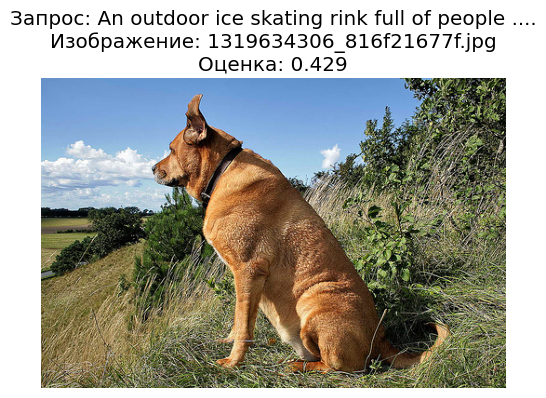


2. Запрос: 'A girl in a purple shirt feeding ducks'
   Результат: This image is unavailable in your country in compliance with local laws.

3. Запрос: 'Boys and girls at a party .'
   Результат: This image is unavailable in your country in compliance with local laws.

4. Запрос: 'A group of girls wearing costumes stand in a park .'
   Результат: This image is unavailable in your country in compliance with local laws.

5. Запрос: 'Two people are sitting on a wooden structure near a tree while conversing .'
   Найденное изображение: 2141713971_e25eb12712.jpg
   Оценка соответствия: 0.198


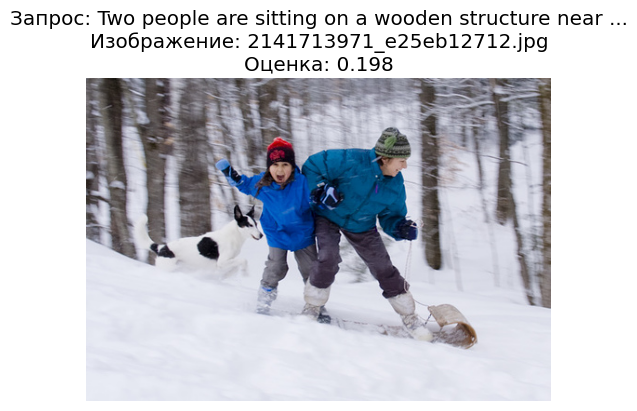


6. Запрос: 'A white dog with a stick in his mouth standing next to a black dog .'
   Найденное изображение: 1319634306_816f21677f.jpg
   Оценка соответствия: 0.316


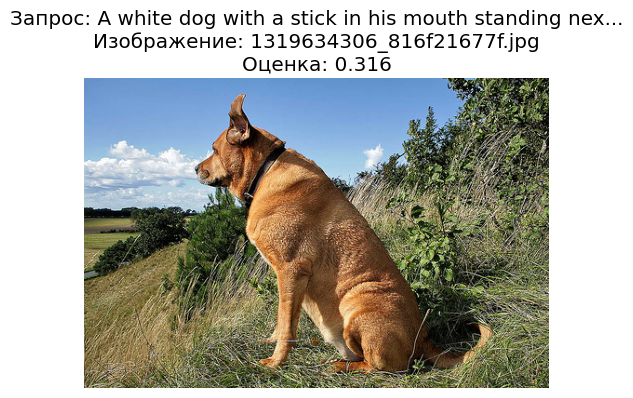


7. Запрос: 'A girl is wearing a purple sash and matching skirt .'
   Результат: This image is unavailable in your country in compliance with local laws.

8. Запрос: 'A person jumping off a dock into water .'
   Найденное изображение: 2141713971_e25eb12712.jpg
   Оценка соответствия: 0.322


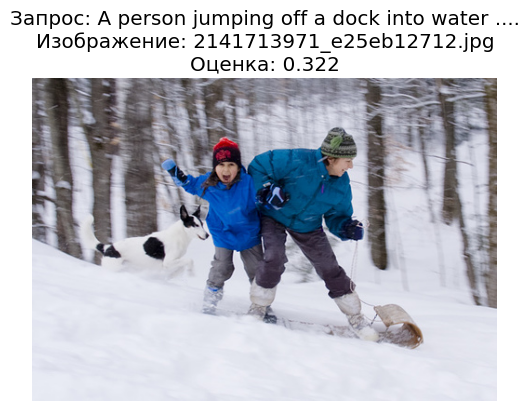


9. Запрос: 'A group of people perform together onstage .'
   Найденное изображение: 2141713971_e25eb12712.jpg
   Оценка соответствия: 0.398


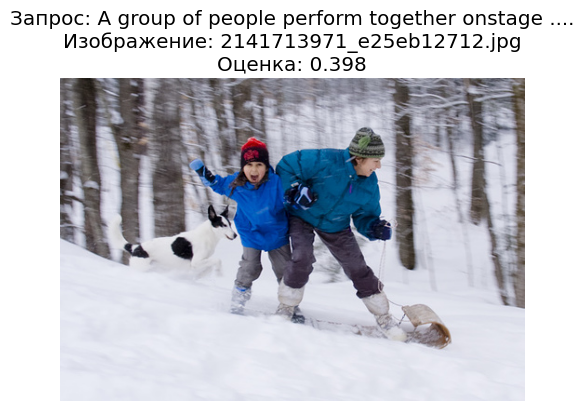


10. Запрос: 'A young boy poses for a picture in front of a playground .'
   Результат: This image is unavailable in your country in compliance with local laws.

Тестирование модели завершено!


In [19]:
# Тестируем функцию на случайных 10 запросах
print("\n=== ДЕМОНСТРАЦИЯ ПОИСКА ===")
import random

# Выбираем случайные 10 запросов
random_queries = random.sample(test_queries['query_text'].tolist(), min(10, len(test_queries)))

for i, query in enumerate(random_queries, 1):
    print(f"\n{i}. Запрос: '{query}'")
    
    # Ищем наиболее подходящее изображение
    results = search_image_by_text(query, top_n=1)
    
    if isinstance(results, str):
        print(f"   Результат: {results}")
    else:
        best_image, score = results[0]
        print(f"   Найденное изображение: {best_image}")
        print(f"   Оценка соответствия: {score:.3f}")
        
        # Показываем изображение
        try:
            img_path = os.path.join(data_path + 'test_images/', best_image)
            img = Image.open(img_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f'Запрос: {query[:50]}...\nИзображение: {best_image}\nОценка: {score:.3f}')
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"   Ошибка при загрузке изображения: {e}")

print("\nТестирование модели завершено!")

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска